In [1]:
using CodecBzip2
using RData
using Distributions
using Statistics
using SpecialFunctions
using Plots
using ProgressMeter
using CSV
using DataFrames
using LinearAlgebra
using Random 
using StatsBase
using ProgressMeter
using StatsPlots
using SynthControl
using Dates
using DataStructures

In [2]:
function SoftmaxLSE(x::Array{Float64})
    c = maximum(x)
    LSE = c + log(sum(exp.(x .- c)))
    return exp.(x .- LSE)
end

SoftmaxLSE (generic function with 1 method)

## Gibbs Sampler

In [3]:
mutable struct gibbsSampler
    A::Int64
    I::Int64
    T::Int64
    K::Int64
    I_K::Array{Float64, 2}
    σU::Float64
    σV::Float64
    σW::Float64
    σ::Array{Float64, 2}
    α::Array{Float64}
    θ::Array{Float64, 2}
    β::Array{Float64, 2}
    Y::Array{Float64, 2}
    X::Array{Float64, 3}
    U::Array{Float64, 2}
    V::Array{Float64, 2}
    W::Array{Float64, 2}
    D::Array{Float64, 2}
    C::Array{Float64}
end

function initGibbs(A::Int64, I::Int64, T::Int64, K::Int64, σU::Float64, σV::Float64, σW::Float64, α::Array{Float64}, θ::Array{Float64, 2}, β::Array{Float64, 2})
    Y = zeros(A, T)
    X = zeros(A, I, T)
    D = zeros(A, I)
    C = zeros(A)
    U = zeros(I, K)
    V = zeros(T, K)
    W = zeros(A, K)
    σ = zeros(A, T)
    I_K = diagm(ones(K))
    return gibbsSampler(A, I, T, K, I_K, σU, σV, σW, σ, α, θ, β, Y, X, U, V, W, D, C)
end

initGibbs (generic function with 1 method)

In [4]:
function sampleU!(gs::gibbsSampler)
    gs.U = rand(Normal(0.0, gs.σU), gs.I, gs.K)
    return gs.U
end

function sampleV!(gs::gibbsSampler)
    gs.V = rand(Normal(0.0, gs.σV), gs.T, gs.K)
    return gs.V
end

function sampleW!(gs::gibbsSampler)
    gs.W = rand(Normal(0.0, gs.σW), gs.A, gs.K)
    return gs.W
end

function sampleσ!(gs::gibbsSampler)
    for a ∈ 1:gs.A
        for t ∈ 1:gs.T
            gs.σ[a, t] = rand(InverseGamma(gs.θ[a, t], gs.β[a, t]))
        end
    end
end

function sampleX!(gs::gibbsSampler)
    for t ∈ 1:gs.T
        for i ∈ 1:gs.I
            for a ∈ 1:gs.A
                gs.X[a, i, t] = rand(Normal(sum(gs.U[i, :] .* gs.V[t, :] .* gs.W[a, :]), gs.σ[a, t]))
            end
        end
    end
end

function sampleD!(gs::gibbsSampler)
    gs.D = rand(Dirichlet(gs.α), gs.A)'
    return gs.D
end

function sampleC!(gs::gibbsSampler)
    for a ∈ 1:gs.A
        gs.C[a] = rand(Categorical(gs.D[a, :]))
    end
    return gs.C
end

function sampleY!(gs::gibbsSampler)
    for t ∈ 1:gs.T
        for a ∈ 1:gs.A
            gs.Y[a, t] = rand(Normal(sum(gs.U[Int64(gs.C[a]), :] .* gs.V[t, :] .* gs.W[a, :]), gs.σ[a, t]))
        end
    end
    return gs.Y
end


function samplePrior!(gs::gibbsSampler)
    sampleU!(gs)
    sampleV!(gs)
    sampleW!(gs)
    sampleσ!(gs)
    sampleX!(gs)
    sampleD!(gs)
    sampleC!(gs)
    sampleY!(gs)
end

samplePrior! (generic function with 1 method)

In [5]:
A = 2
I = 50
T = 30
K = 3
σ = 0.01
θ = ones(A, T)
β = ones(A, T)
α = 1.0/Float64(I) * ones(I)

gs = initGibbs(A, I, T, K, σ, σ, σ, α, θ, β)

@time for i ∈ 1:1000 samplePrior!(gs) end

  1.183397 seconds (12.31 M allocations: 940.539 MiB, 17.26% gc time, 0.88% compilation time)


In [20]:
function updateU!(gs::gibbsSampler)
    SX = zeros(gs.K, gs.K)
    SY = zeros(gs.K, gs.K)

    bY = zeros(gs.K)
    bX = zeros(gs.K)
    
    for t ∈ 1:gs.T
        for a ∈ 1:gs.A
            SX += ((gs.V[t, :] .* gs.W[a, :]) * (gs.V[t, :] .* gs.W[a, :])') ./ gs.σ[a,t]
        end
    end
    
    for i ∈ 1:gs.I
        bX .= 0.0
        bY .= 0.0
        SY .= 0.0
        
        for t ∈ 1:gs.T
            for a ∈ 1:gs.A
                bX += ((gs.V[t, :] .* gs.W[a, :]) .* gs.X[a,i,t]) ./ gs.σ[a,t]
                if i == Int64(gs.C[a])
                    bY += ((gs.V[t, :] .* gs.W[a, :]) .* gs.Y[a,t]) ./ gs.σ[a,t]
                    SY += ((gs.V[t, :] .* gs.W[a, :]) * (gs.V[t, :] .* gs.W[a, :])') ./ gs.σ[a,t]
                end
            end
        end
        
        MVN = MvNormalCanon(bY + bX, 1.0/gs.σU .* gs.I_K + SX + SY)
        gs.U[i, :] = rand(MVN)
    end
    return gs.U
end

function updateV!(gs::gibbsSampler)
    SX = zeros(gs.K, gs.K)
    SY = zeros(gs.K, gs.K)
    bY = zeros(gs.K)
    bX = zeros(gs.K)
    
    for t ∈ 1:gs.T
        SX .= 0.0
        SY .= 0.0
        bX .= 0.0
        bY .= 0.0
        for i ∈ 1:gs.I
            for a ∈ 1:gs.A
                SX += ((gs.U[i, :] .* gs.W[a, :]) * (gs.U[i, :] .* gs.W[a, :])') ./ gs.σ[a,t]
                bX += ((gs.U[i, :] .* gs.W[a, :]) .* gs.X[a,i,t]) ./ gs.σ[a,t]
                if i == Int64(gs.C[a])
                    bY += ((gs.U[i, :] .* gs.W[a, :]) .* gs.Y[a,t]) ./ gs.σ[a,t]
                    SY += ((gs.U[i, :] .* gs.W[a, :]) * (gs.U[i, :] .* gs.W[a, :])') ./ gs.σ[a,t]
                end
            end
        end
        MVN = MvNormalCanon(bY + bX, 1.0/gs.σV .* gs.I_K + SY + SX)
        gs.V[t, :] = rand(MVN)
    end
    return gs.V
end

function updateW!(gs::gibbsSampler)
    SX = zeros(gs.K, gs.K)
    SY = zeros(gs.K, gs.K)

    bY = zeros(gs.K)
    bX = zeros(gs.K)
    
    for a ∈ 1:gs.A
        bX .= 0.0
        bY .= 0.0
        SY .= 0.0
        SX .= 0.0
        for i ∈ 1:gs.I
            for t ∈ 1:gs.T
                bX += ((gs.U[i, :] .* gs.V[t, :]) .* gs.X[a,i,t]) ./ gs.σ[a,t]
                SX += ((gs.U[i, :] .* gs.V[t, :]) * (gs.U[i, :] .* gs.V[t, :])') ./ gs.σ[a,t]

                if i == Int64(gs.C[a])
                    bY += ((gs.V[t, :] .* gs.W[a, :]) .* gs.Y[a,t]) ./ gs.σ[a,t]
                    SY += ((gs.V[t, :] .* gs.W[a, :]) * (gs.V[t, :] .* gs.W[a, :])') ./ gs.σ[a,t]
                end
            end
        end
        MVN = MvNormalCanon(bY + bX, 1.0/gs.σW .* gs.I_K + SY + SX)
        gs.W[a, :] = rand(MVN)
    end
    return gs.W
end

function updateσ!(gs::gibbsSampler)
    for t ∈ 1:gs.T
        for a ∈ 1:gs.A
            shape = gs.θ[a,t] + 0.5*(Float64(gs.I) + 1.0)
            scale = gs.β[a,t]
            for i ∈ 1:gs.I
                scale += 0.5*(gs.X[a, i, t] - sum(gs.U[i, :] .* gs.V[t, :] .* gs.W[a, :]))^2
            end
            scale += 0.5*(gs.Y[t] - sum(gs.U[Int64(gs.C[a]), :] .* gs.V[t, :] .* gs.W[a, :]))^2
            gs.σ[a,t] = min(rand(InverseGamma(shape, scale)), 1e4)
            #gs.σ[a,t] = rand(InverseGamma(shape, scale))
        end
    end
    #println(gs.σ)
    return gs.σ
end

function updateD!(gs::gibbsSampler)
    for a ∈ 1:gs.A
        param = deepcopy(gs.α)
        param[Int64(gs.C[a])] += 1.0
        gs.D[a, :] = rand(Dirichlet(param))
    end
    return gs.D
end

function updateC!(gs::gibbsSampler)
    for a ∈ 1:gs.A
        probs = zeros(gs.I)
        N = 0.0
        for i ∈ 1:gs.I
            for t ∈ 1:gs.T
                N += 0.5 * log(2*π) - log(gs.σ[a,t]) - 0.5 * 1.0/gs.σ[a,t] * (gs.Y[a, t] - sum(gs.U[i, :] .* gs.V[t, :] .* gs.W[a, :]))^2
            end
            probs[i] = N - log(gs.D[i] + 1e-8)
        end
        probs = SoftmaxLSE(probs)
        gs.C[a] = rand(Categorical(probs ./sum(probs)))
    end
    return gs.C
end

function updateX!(gs::gibbsSampler, mask::Set{Tuple{Int64, Int64, Int64}})
    for i ∈ mask
        gs.X[i[1], i[2], i[3]] = rand(Normal(sum(gs.U[i[2], :] .* gs.V[i[3], :] .* gs.W[i[1], :]), gs.σ[i[1], i[3]]))
    end
    return gs.X
end

function updateY!(gs::gibbsSampler, mask::Set{Tuple{Int64, Int64}})
    for i ∈ mask
        gs.Y[i[1], i[2]] = rand(Normal(sum(gs.U[Int64(gs.C[i[1]]), :] .* gs.V[i[2], :] .* gs.W[i[1], :]), gs.σ[i[1], i[2]]))
    end
    return gs.Y
end

function predictY(gs::gibbsSampler)
    Y = zeros(gs.A, gs.T)
    for a ∈ 1:gs.A
        for t ∈ 1:gs.T
            Y[a, t] = rand(Normal(sum(gs.U[Int64(gs.C[a]), :] .* gs.V[t, :] .* gs.W[a, :]), gs.σ[a, t]))
        end
    end
    return Y
end

function updateGibbs!(gs::gibbsSampler, maskY::Set{Tuple{Int64, Int64}}, maskX::Set{Tuple{Int64, Int64, Int64}})
    updateU!(gs)
    updateW!(gs)
    updateV!(gs)
    updateσ!(gs)
    updateC!(gs)
    updateD!(gs)
    updateX!(gs, maskX)
    updateY!(gs, maskY)
    return gs
end

function updateGibbsNoσ!(gs::gibbsSampler, mask::Set{Tuple{Int64, Int64}})
    updateU!(gs)
    updateW!(gs)
    updateV!(gs)
    updateC!(gs)
    updateD!(gs)
    updateY!(gs, mask)
    return gs
end

function updateGeweke!(gs::gibbsSampler)
    updateU!(gs)
    updateW!(gs)
    updateV!(gs)
    updateσ!(gs)
    updateC!(gs)
    updateD!(gs)
    sampleX!(gs)
    sampleY!(gs)
    return gs
end

updateGeweke! (generic function with 2 methods)

## Geweke Testing

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


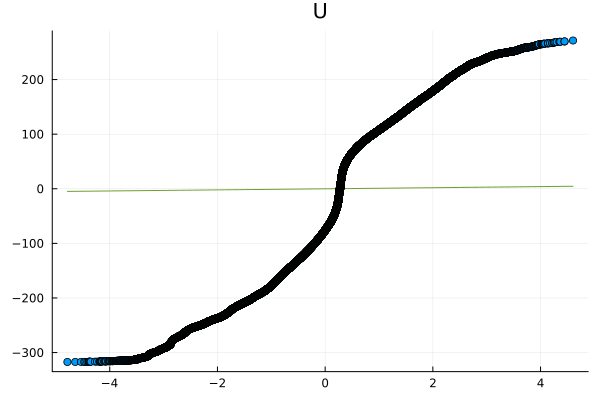

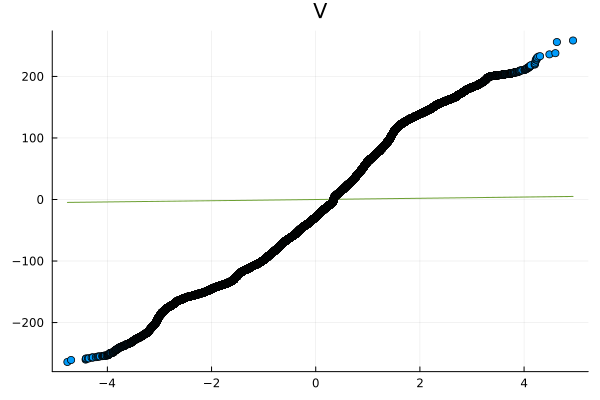

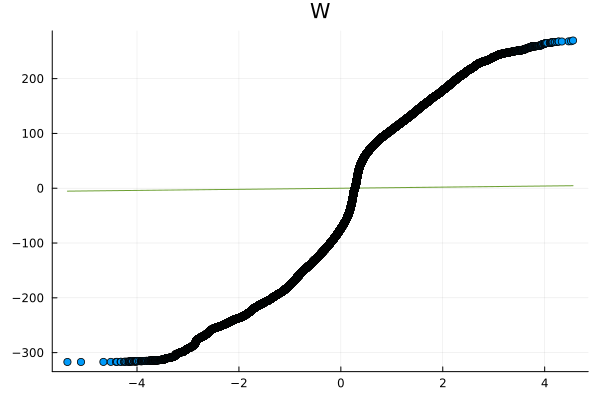

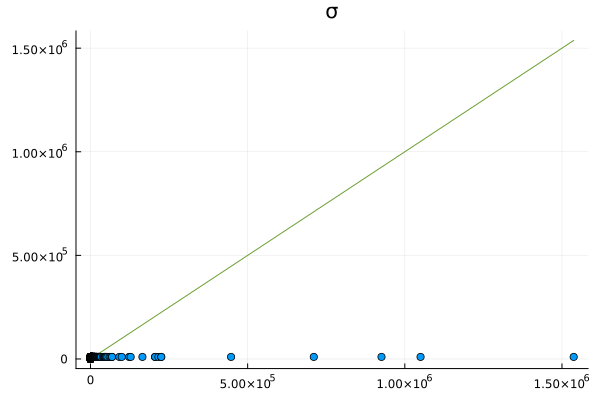

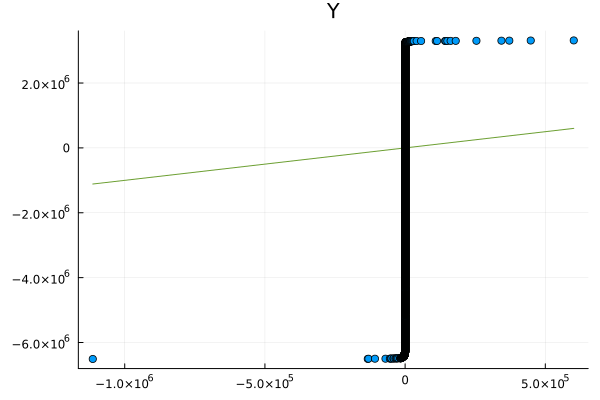

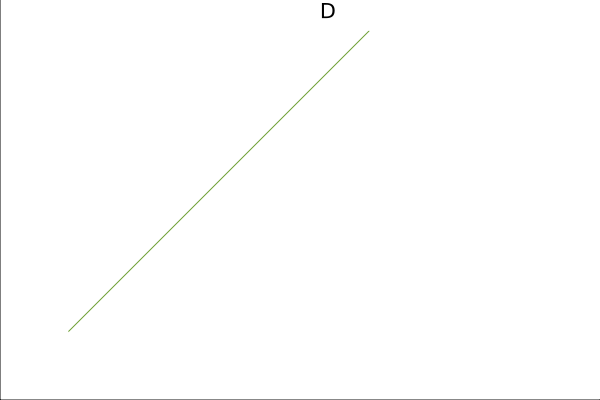

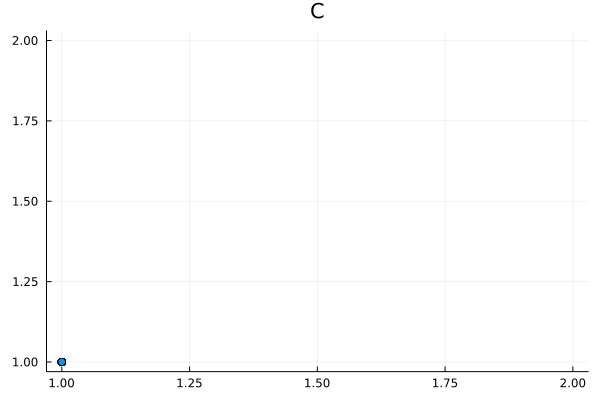

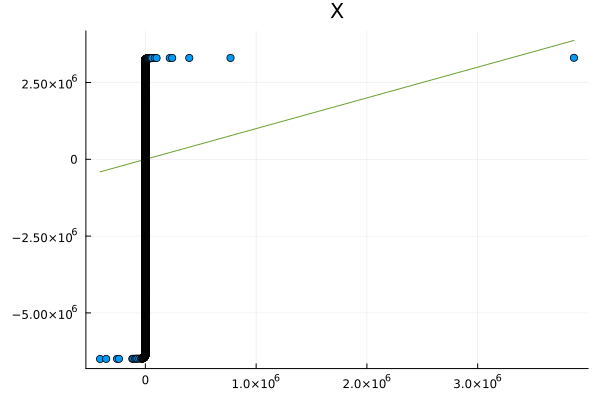

In [71]:
A = 1
I = 1
T = 1
K = 1
θ = ones(A, T)
β = ones(A, T)
α = 1.0/Float64(I) * ones(I)

gs = initGibbs(A, I, T, K, σ, σ, σ, α, θ, β)

numItr = 1000000

statU = zeros(2, numItr)
statV = zeros(2, numItr)
statW = zeros(2, numItr)
statσ = zeros(2, numItr)
statY = zeros(2, numItr)
statD = zeros(2, numItr)
statC = zeros(2, numItr)
statX = zeros(2, numItr)

@showprogress for i ∈ 1:numItr
    samplePrior!(gs)
    statU[1, i] = mean(gs.U)
    statV[1, i] = mean(gs.V)
    statW[1, i] = mean(gs.W)
    statσ[1, i] = mean(gs.σ)
    statY[1, i] = mean(gs.Y)
    statD[1, i] = maximum(gs.D)
    statC[1, i] = mean(gs.C)
    statX[1, i] = mean(gs.X)
end
@showprogress for i ∈ 1:numItr
    updateGeweke!(gs)
end
@showprogress for i ∈ 1:numItr
    updateGeweke!(gs)
    statU[2, i] = mean(gs.U)
    statV[2, i] = mean(gs.V)
    statW[2, i] = mean(gs.W)
    statσ[2, i] = mean(gs.σ)
    statY[2, i] = mean(gs.Y)
    statD[2, i] = maximum(gs.D)
    statC[2, i] = mean(gs.C)
    statX[2, i] = mean(gs.X)
end

display(qqplot(statU[1,:], statU[2,:], title="U", fmt=:png))
display(qqplot(statV[1,:], statV[2,:], title="V", fmt=:png))
display(qqplot(statW[1,:], statW[2,:], title="W", fmt=:png))
display(qqplot(statσ[1,:], statσ[2,:], title="σ", fmt=:png))
display(qqplot(statY[1,:], statY[2,:], title="Y", fmt=:png))
display(qqplot(statD[1,:], statD[2,:], title="D", fmt=:png))
display(qqplot(statC[1,:], statC[2,:], title="C", fmt=:png))
display(qqplot(statX[1,:], statX[2,:], title="X", fmt=:png))


## California Smoking Data

In [40]:
data = load("smoking.rda")["smoking"]
numStates = 39
numYears = 31
# California is state 3 and the intervention happened in 1989
A = 1
T = numYears
I = numStates

Y = zeros(A, T)
X = zeros(A, I-1, T)

YObs = zeros(A+1, I, T)
for row ∈ eachrow(data)
    if row["state"] == 3 && Int64(row["year"]) > 1988
        YObs[2, Int64(row["state"]), Int64(row["year"] - 1969.0)] = row["cigsale"]
    else
        YObs[1, Int64(row["state"]), Int64(row["year"] - 1969.0)] = row["cigsale"] 
    end
end

Y = deepcopy(YObs[:, 3, :])
for a ∈ 1:A
    for i ∈ 1:I
        for t ∈ 1:T
            if i > 3
                X[a, i-1, t] = YObs[a,i,t]
            elseif i < 3
                X[a, i, t] = YObs[a,i,t]
            end
        end
    end
end

maskY = Set{Tuple{Int64, Int64}}()

for a ∈ 1:A
    for t ∈ 1:T
        if Y[a,t] == 0.0
            push!(maskY, (a, t))
        end
    end
end

maskX = Set{Tuple{Int64, Int64, Int64}}()

for a ∈ 1:A
    for i ∈ 1:I-1
        for t ∈ 1:T
            if X[a,i,t] == 0.0
                push!(maskX, (a, i, t))
            end
        end
    end
end

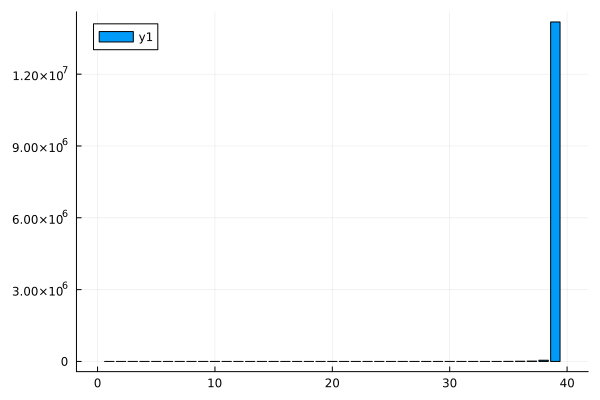

In [41]:
e = eigen(YObs[1, :, 1:1989-1969+1]*YObs[1,:,1:1989-1969+1]')
bar(real.(e.values))

In [49]:
numItr = 10000
K = 1
σ = 1.0
α = 1.0/(I-1) * ones(I-1)
θ = ones(A, T)
β = ones(A, T)

gs = initGibbs(A, I-1, T, K, σ, σ, σ, α, θ, β)

samplePrior!(gs)
gs.Y = deepcopy(Y)
gs.X = deepcopy(X)
#gs.σ .= mean(X)
#=
for t ∈ 1:T
    gs.σ[1, t] = mean(X[1, :, t])
end
=#
Ysamples = zeros(numItr, A, T)
sampleC = zeros(numItr, A)

@showprogress for i ∈ 1:numItr
    updateGibbs!(gs, maskY, maskX)
end

@showprogress for i ∈ 1:numItr
    updateGibbs!(gs, maskY, maskX)
    Ysamples[i, :, :] = predictY(gs)
    sampleC[i, :] = deepcopy(gs.C)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


In [66]:

tensorPred = mean(Ysamples[:, 1, :], dims=1)'
errUpTensor = zeros(T)
errDownTensor = zeros(T)
for t ∈ 1:T
    errUpTensor[t] = quantile(Ysamples[:, 1, t], 0.51)
    errDownTensor[t] = quantile(Ysamples[:, 1, t], 0.49)
end

In [67]:
#Standard California Synthetic Control
df = load_smoking()
panel = load_smoking_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-8.44, -9.207, -12.633, -13.727, -17.531, -22.047, -22.857, -23.996, -26.258, -23.341, -27.522, -26.598]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: 3
    Number of untreated units: 38
    First treatment period: 1989
    Number of pretreatment periods: 19
    Number of treatment periods: 12


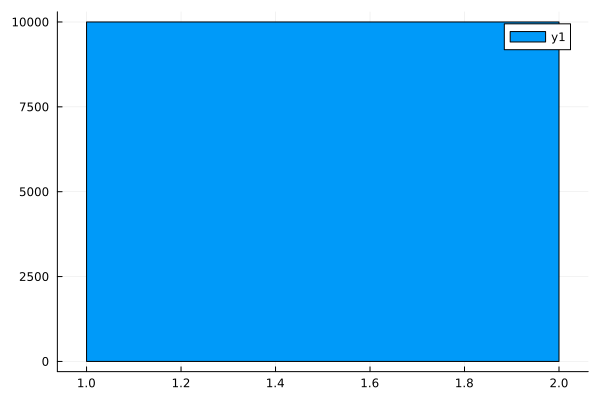

In [68]:
histogram(sampleC[:, 1], bins=I-1)

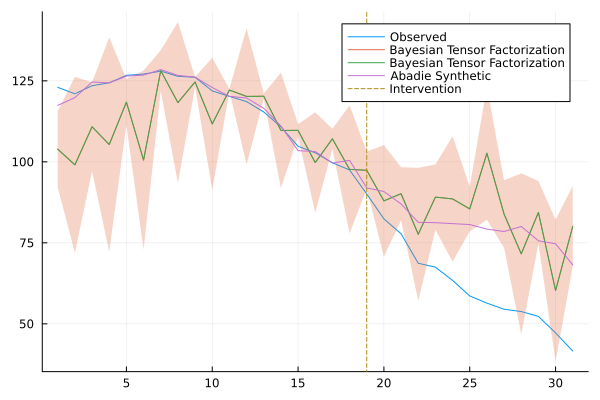

In [69]:
plot([YObs[1, 3, 1:19]; YObs[2, 3, 20:end]], label="Observed")
#plot!(mean(sampleY[:, 1, :], dims=1)', label="Bayesian Synthetic")
#plot!(Ysamples[end-5, 1, :], label="Single sample Bayesian Synthetic")
plot!(tensorPred, ribbon=errUpTensor - errDownTensor, fillalpha=.3, label="Bayesian Tensor Factorization")
plot!(tensorPred, label="Bayesian Tensor Factorization")

plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([19], label="Intervention",  seriestype = :vline, line=:dash)

## Basque Data

In [231]:
# Basque is region 17 and the intervention happened in 1975 or timestep 22
df = load_basque()

A = 2
I = 18
T = 43

Y = zeros(A, T)
X = zeros(A, I-1, T)

YObs = zeros(A, I, T)

for i ∈ eachrow(df)
    if i["regionno"] == 17 && i["year"] > 1975
        YObs[2, i["regionno"], i["year"]-1955+1] = i["gdpcap"]
    else
        YObs[1, i["regionno"], i["year"]-1955+1] = i["gdpcap"]
    end
end

Y = deepcopy(YObs[:, 17, :])
for a ∈ 1:A
    for i ∈ 1:I
        for t ∈ 1:T
            if i > 17
                X[a, i-1, t] = YObs[a,i,t]
            elseif i < 17
                X[a, i, t] = YObs[a,i,t]
            end
        end
    end
end

mask = Set{Tuple{Int64, Int64}}()

for a ∈ 1:A
    for t ∈ 1:T
        if Y[a,t] == 0.0
            push!(mask, (a, t))
        end
    end
end

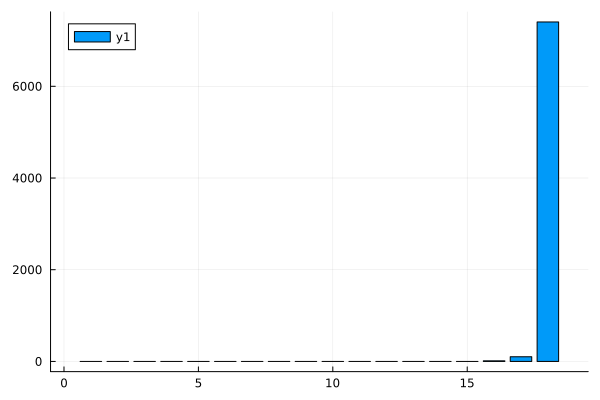

In [232]:
e = eigen(YObs[1, :, 1:1998-1975]*YObs[1,:,1:1998-1975]')
bar(real.(e.values))

In [233]:
numItr = 1000
K = 2
σ = mean(X)
α = 1.0/(I-1) * ones(I-1)
θ = ones(A, T) .* σ
β = ones(A, T) ./ σ

gs = initGibbs(A, I-1, T, K, σ, σ, σ, α, θ, β)

samplePrior!(gs)
gs.Y = deepcopy(Y)
gs.X = deepcopy(X)
gs.σ .= mean(X)
sampleY = zeros(numItr, A, T)

@showprogress for i ∈ 1:numItr
    updateGibbsNoσ!(gs, mask)
end

@showprogress for i ∈ 1:numItr
    updateGibbsNoσ!(gs, mask)
    sampleY[i, :, :] = predictY(gs)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [234]:
panel = load_basque_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-0.12, -0.197, -0.3, -0.402, -0.221, -0.047, -0.187, -0.321, -0.534, -0.643  …  -1.457, -1.445, -1.365, -1.321, -1.291, -1.269, -1.263, -1.108, -1.08, -1.012]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: Basque Country (Pais Vasco)
    Number of untreated units: 17
    First treatment period: 1970
    Number of pretreatment periods: 15
    Number of treatment periods: 28


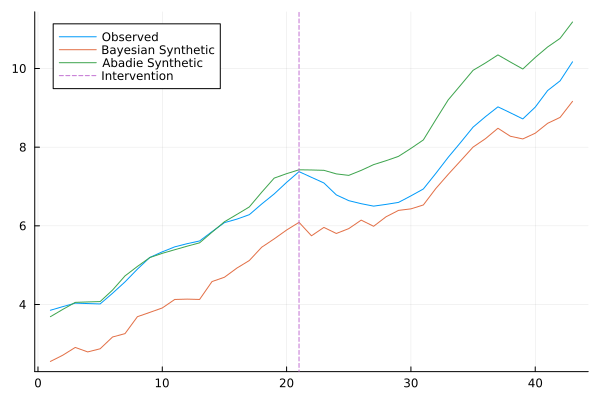

In [235]:
plot([YObs[1, 17, 1:21]; YObs[2, 17, 22:end]], label="Observed")
plot!(mean(sampleY[:, 1, :], dims=1)', label="Bayesian Synthetic")
plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([21], label="Intervention",  seriestype = :vline, line=:dash)

## Germany Data

In [236]:
# Germany is region 7 and the intervention happened in 1990 or timestep 30
df = load_germany()

A = 2
I = 18
T = 44
Y = zeros(A, T)
X = zeros(A, I-1, T)

YObs = zeros(A, I, T)

for i ∈ eachrow(df)
    if i["index"] == 12
        i["index"] = 11
    end
    if i["index"] == 14
        i["index"] = 12
    end
    if i["index"] == 16
        i["index"] = 13
    end
    if i["index"] == 18
        i["index"] = 14
    end
    if i["index"] == 19
        i["index"] = 15
    end
    if i["index"] == 20
        i["index"] = 16
    end
    if i["index"] == 21
        i["index"] = 17
    end
    if i["index"] == 7 && i["year"] > 1989
        YObs[2, i["index"], i["year"]-1960+1] = i["gdp"]
    else
        YObs[1, i["index"], i["year"]-1960+1] = i["gdp"]
    end
end

Y = deepcopy(YObs[:, 7, :])
for a ∈ 1:A
    for i ∈ 1:I
        for t ∈ 1:T
            if i > 7
                X[a, i-1, t] = YObs[a,i,t]
            elseif i < 7
                X[a, i, t] = YObs[a,i,t]
            end
        end
    end
end

mask = Set{Tuple{Int64, Int64}}()

for a ∈ 1:A
    for t ∈ 1:T
        if Y[a,t] == 0.0
            push!(mask, (a, t))
        end
    end
end

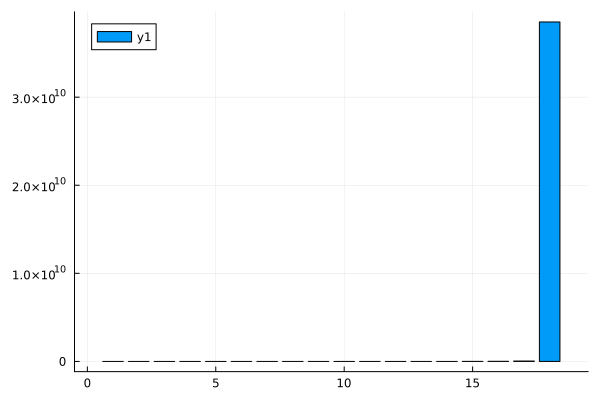

In [237]:
e = eigen(YObs[1, :, 1:44-14]*YObs[1,:,1:44-14]')
bar(real.(e.values))

In [238]:
numItr = 1000
K = 1
σ = mean(X)
α = 1.0/(I-1) * ones(I-1)
θ = ones(A, T) .* σ
β = ones(A, T) ./ σ

gs = initGibbs(A, I-1, T, K, σ, σ, σ, α, θ, β)

samplePrior!(gs)
gs.Y = deepcopy(Y)
gs.X = deepcopy(X)
gs.σ .= mean(X)

sampleY = zeros(numItr, A, T)

@showprogress for i ∈ 1:numItr
    updateGibbsNoσ!(gs, mask)
end

@showprogress for i ∈ 1:numItr
    updateGibbsNoσ!(gs, mask)
    sampleY[i, :, :] = predictY(gs)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [239]:
panel = load_germany_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\nihar\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148



Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [351.759, 769.549, 585.335, -166.047, -630.087, -784.339, -1012.161, -1626.912, -1803.083, -2083.991, -2657.6, -2900.057, -3064.183, -3532.909]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: West Germany
    Number of untreated units: 16
    First treatment period: 1990
    Number of pretreatment periods: 30
    Number of treatment periods: 14


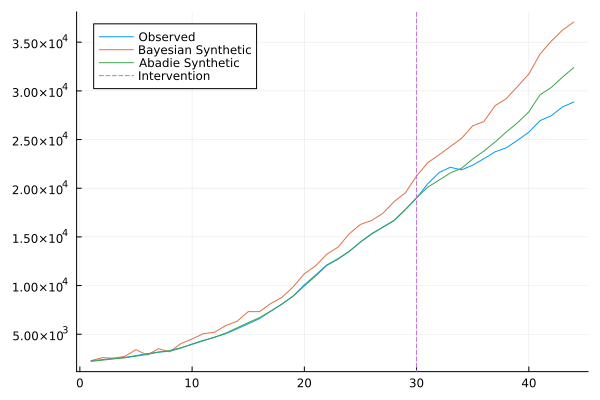

In [240]:
plot([YObs[1, 7, 1:44-14]; YObs[2, 7, 44-14+1:end]], label="Observed")
plot!(mean(sampleY[:, 1, :], dims=1)', label="Bayesian Synthetic")
plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([44-14], label="Intervention",  seriestype = :vline, line=:dash)

## Brexit Data

In [241]:
#Standard Brexit Synthetic Control, Intervention happeed at timestep 31, Britain is country 22
df = load_brexit()
A = 2
I = 23
T = 39

Y = zeros(A, T)
X = zeros(A, I-1, T)

YObs = zeros(A, I, T)

IMap = unique(df[!, "country"])
TMap = unique(df[!, "quarter"])

for i ∈ eachrow(df)
    state = findfirst(==(i["country"]), IMap)
    time = findfirst(==(i["quarter"]), TMap)
    if state == 22 && time > 30
        YObs[2, state, time] = i["realgdp"]
    else
        YObs[1, state, time] = i["realgdp"]
    end
end


Y = deepcopy(YObs[:, 22, :])
for a ∈ 1:A
    for i ∈ 1:I
        for t ∈ 1:T
            if i > 22
                X[a, i-1, t] = YObs[a,i,t]
            elseif i < 22
                X[a, i, t] = YObs[a,i,t]
            end
        end
    end
end

mask = Set{Tuple{Int64, Int64}}()

for a ∈ 1:A
    for t ∈ 1:T
        if Y[a,t] == 0.0
            push!(mask, (a, t))
        end
    end
end

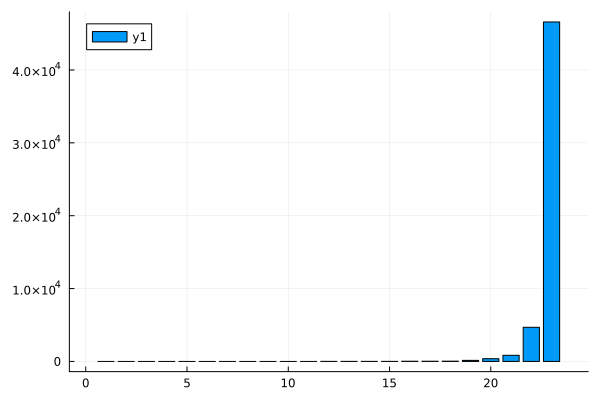

In [242]:
e = eigen(YObs[1, :, 1:30]*YObs[1,:,1:30]')
bar(real.(log.(Complex.(e.values))))
bar(real.(e.values))

In [243]:
panel = load_brexit_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-0.54, -0.31, -0.206, -0.732, -1.241, -1.482, -1.818, -2.327, -1.994]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: United Kingdom
    Number of untreated units: 22
    First treatment period: 2016-07-01
    Number of pretreatment periods: 30
    Number of treatment periods: 9


In [244]:
numItr = 1000
K = 4
σ = mean(X)
α = 1.0/(I-1) * ones(I-1)
θ = ones(A, T) .* σ
β = ones(A, T) ./ σ

gs = initGibbs(A, I-1, T, K, σ, σ, σ, α, θ, β)

samplePrior!(gs)
gs.Y = deepcopy(Y)
gs.X = deepcopy(X)
gs.σ .= mean(X)

sampleY = zeros(numItr, A, T)

@showprogress for i ∈ 1:numItr
    updateGibbsNoσ!(gs, mask)
end

@showprogress for i ∈ 1:numItr
    updateGibbsNoσ!(gs, mask)
    sampleY[i, :, :] = predictY(gs)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


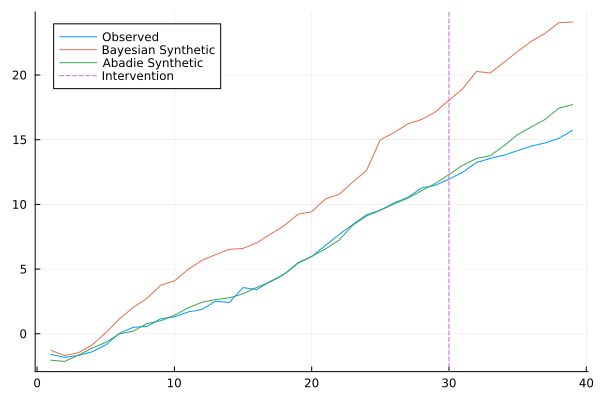

In [245]:
plot([YObs[1, 22, 1:30]; YObs[2, 22, 31:end]], label="Observed")
plot!(mean(sampleY[:, 1, :], dims=1)', label="Bayesian Synthetic")
plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([30], label="Intervention",  seriestype = :vline, line=:dash)